
### Submitted By: Capstone Group 1 - AIML MAY Group - 3
### Project: AIML Online Capstone - Pneumonia Detection Challenge - OD - UnetMobilenet

#### OBJECTIVE
To build a pneumonia detection system, to locate the position of inflammation in an image.
#### CONTEXT
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
#### DATA DESCRIPTION
Dicom original images: - Medical images are stored in a special format called DICOM files (\*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

### Step 1 - Perform imports

Let us imports all required packages before importing dataset

In [1]:
# Adding imports required for data cleansing and visualization
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

# Adding imports for misc and data prep
import os
import cv2
import pydicom #For displaying dcm images

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.6.3'

In [3]:
# Initialize the random number generator
import random

np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

from sklearn.model_selection import train_test_split

# NN Core imports
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import to_categorical, plot_model

Looking at the dir structure

In [4]:
# Lets have a look at the dir structure
!find ../input -type d 

../input
../input/od-mobilenet-ds


Define input path parameters

In [5]:
input_path = "../input/od-mobilenet-ds/"

training_images_mobnet_path = input_path + 'training_images_mobnet.pkl'
training_masks_mobnet_path = input_path + 'training_masks_mobnet.pkl'

### Step 2 - Load data from saved data source

Let us load training images and mask arrays

In [6]:
# Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
ALPHA = 1

# Original image size referred from input data set
originalImageSize = 1024

# Ref: https://arxiv.org/pdf/1704.04861.pdf (Mobilenet paper shows that expected input image size is 224x224x3)
IMAGE_SIZE = 224

In [7]:
with open(training_images_mobnet_path,'rb') as file:
    training_images_mobnet = pickle.load(file)
    print("training_images_mobnet -> Loading Complete")

with open(training_masks_mobnet_path,'rb') as file:
    training_masks_mobnet = pickle.load(file)
    print("training_masks_mobnet -> Loading Complete")

training_images_mobnet -> Loading Complete
training_masks_mobnet -> Loading Complete


### Step 3 - Data Prep for modeling

**- Check shape of pre-processed images -**

In [8]:
print ("Shape of training_images_mobnet is -> ", training_images_mobnet.shape)
print ("Shape of training_masks_mobnet is -> ", training_masks_mobnet.shape)

Shape of training_images_mobnet is ->  (2000, 224, 224, 3)
Shape of training_masks_mobnet is ->  (2000, 224, 224)


In [9]:
X_train_mobnet, X_test_mobnet, y_train_mobnet, y_test_mobnet = train_test_split(
    training_images_mobnet, 
    training_masks_mobnet, 
    test_size=0.2, random_state=1, shuffle=False)

X_val_mobnet, X_test_mobnet, y_val_mobnet, y_test_mobnet = train_test_split(
    X_test_mobnet, 
    y_test_mobnet, 
    test_size=0.2, random_state=1, shuffle=False)

print("Shape of X_train -> ", X_train_mobnet.shape, ", Shape of y_train -> ", y_train_mobnet.shape)
print("Shape of X_val -> ", X_val_mobnet.shape, ", Shape of y_val -> ", y_val_mobnet.shape)
print("Shape of X_test -> ", X_test_mobnet.shape, ", Shape of y_test -> ", y_test_mobnet.shape)

Shape of X_train ->  (1600, 224, 224, 3) , Shape of y_train ->  (1600, 224, 224)
Shape of X_val ->  (320, 224, 224, 3) , Shape of y_val ->  (320, 224, 224)
Shape of X_test ->  (80, 224, 224, 3) , Shape of y_test ->  (80, 224, 224)


### Step 4 - Model design and fit

**- Let's design our model -**

In [10]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_SIZE, IMAGE_SIZE))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock)

**--Let us create out model now...**

In [11]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

model = create_model()

# Print summary
model.summary()

2022-05-07 07:08:40.377940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 07:08:40.389857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 07:08:40.390550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 07:08:40.391653: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

**Design your own Dice Coefficient and Loss function.**

Define dice coefficient

In [12]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    # reduce_sum(), computes the sum of elements across dimensions of a tensor.
    # Since the 2nd arg, i.e., axis of reduce_sum() is 'None', it reduces all dimensions, 
    # and a tensor with a single element is returned.
    
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

Define Loss function

In [13]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

**Train, tune and test the model.**

Compile the model

In [14]:
# To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Defining optimizer and compile
optimizer = Adam(lr=0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient, Recall(), Precision()])

# We need not compute Recall() and Precision() in image recognition, especially when we have dice_coefficient.
# We are still doing it as a good practice.

In [15]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
    ,ModelCheckpoint('OD_UnetMobileNet_CP_Weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
    ,EarlyStopping(monitor='val_loss', patience=10)
]

Train the Model

In [16]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

uNet_hist = model.fit(
    X_train_mobnet,
    y_train_mobnet,
    validation_data = (X_val_mobnet, y_val_mobnet),
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=1)

2022-05-07 07:08:42.742692: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 963379200 exceeds 10% of free system memory.
2022-05-07 07:08:44.210359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 321126400 exceeds 10% of free system memory.
2022-05-07 07:08:44.574358: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 963379200 exceeds 10% of free system memory.
2022-05-07 07:08:45.315516: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 321126400 exceeds 10% of free system memory.
2022-05-07 07:08:45.652302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-07 07:08:48.581796: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - ETA: 0s - loss: 3.1548 - dice_coefficient: 0.1239 - recall: 0.2867 - precision: 0.0753

2022-05-07 07:09:26.454154: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 192675840 exceeds 10% of free system memory.


200/200 [==============================] - 47s 196ms/step - loss: 3.1548 - dice_coefficient: 0.1239 - recall: 0.2867 - precision: 0.0753 - val_loss: 1.7012 - val_dice_coefficient: 0.2527 - val_recall: 0.2034 - val_precision: 0.3264

Epoch 00001: val_loss improved from inf to 1.70122, saving model to OD_UnetMobileNet_CP_Weights.h5
Epoch 2/50
200/200 [==============================] - 37s 187ms/step - loss: 2.2011 - dice_coefficient: 0.1885 - recall: 0.3418 - precision: 0.1841 - val_loss: 1.5722 - val_dice_coefficient: 0.2839 - val_recall: 0.2678 - val_precision: 0.3295

Epoch 00002: val_loss improved from 1.70122 to 1.57222, saving model to OD_UnetMobileNet_CP_Weights.h5
Epoch 3/50
200/200 [==============================] - 37s 187ms/step - loss: 2.3099 - dice_coefficient: 0.2088 - recall: 0.3519 - precision: 0.2152 - val_loss: 1.5287 - val_dice_coefficient: 0.3009 - val_recall: 0.3063 - val_precision: 0.3261

Epoch 00003: val_loss improved from 1.57222 to 1.52868, saving model to OD_Un

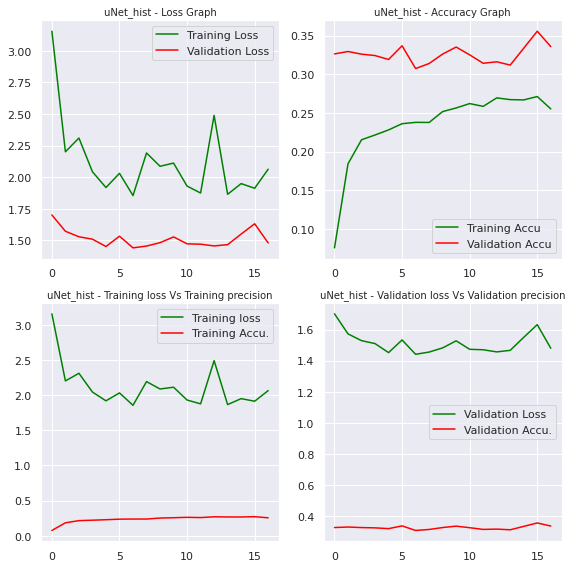

In [17]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax[0, 0].set_title("uNet_hist - Loss Graph", fontsize=10)
ax[0, 0].plot(uNet_hist.history["loss"], color='green')
ax[0, 0].plot(uNet_hist.history["val_loss"], color='red')
ax[0, 0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[0, 1].set_title("uNet_hist - Accuracy Graph", fontsize=10)
ax[0, 1].plot(uNet_hist.history["precision"], color='green')
ax[0, 1].plot(uNet_hist.history["val_precision"], color='red')
ax[0, 1].legend(["Training Accu", "Validation Accu"], loc='best')

ax[1, 0].set_title("uNet_hist - Training loss Vs Training precision", fontsize=10)
ax[1, 0].plot(uNet_hist.history["loss"], color='green')
ax[1, 0].plot(uNet_hist.history["precision"], color='red')
ax[1, 0].legend(["Training loss", "Training Accu."], loc='best')

ax[1, 1].set_title("uNet_hist - Validation loss Vs Validation precision", fontsize=10)
ax[1, 1].plot(uNet_hist.history["val_loss"], color='green')
ax[1, 1].plot(uNet_hist.history["val_precision"], color='red')
ax[1, 1].legend(["Validation Loss", "Validation Accu."], loc='best')

plt.tight_layout()
plt.show()

**Evaluate the model using testing data.**

In [18]:
model.evaluate(X_test_mobnet, y_test_mobnet, batch_size=8)

10/10 [==============================] - 1s 131ms/step - loss: 1.3450 - dice_coefficient: 0.3661 - recall: 0.3883 - precision: 0.3888


[1.345017671585083,
 0.36605173349380493,
 0.38829943537712097,
 0.3888000249862671]

### Step 5 - Prediction with models

#### Step 5.1 Perform prediction with fit model and perform save()

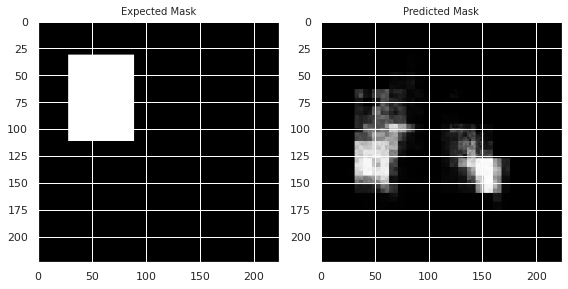

In [19]:
# Prediction for image-5
img = X_test_mobnet[5].astype('uint32')
image_array = np.array([img])
pred_image = model.predict(image_array)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].set_title("Expected Mask", fontsize=10)
ax[0].imshow(y_test_mobnet[5], cmap=plt.cm.gist_gray)
ax[1].set_title("Predicted Mask", fontsize=10)
ax[1].imshow(pred_image[0], cmap=plt.cm.gist_gray)
plt.tight_layout()
plt.show()

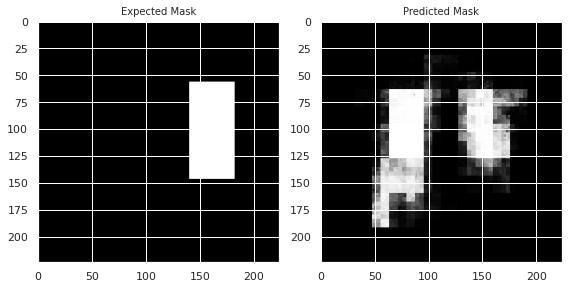

In [20]:
# Prediction for image-15
img = X_test_mobnet[15].astype('uint32')
image_array = np.array([img])
pred_image = model.predict(image_array)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].set_title("Expected Mask", fontsize=10)
ax[0].imshow(y_test_mobnet[15], cmap=plt.cm.gist_gray)
ax[1].set_title("Predicted Mask", fontsize=10)
ax[1].imshow(pred_image[0], cmap=plt.cm.gist_gray)
plt.tight_layout()
plt.show()

In [21]:
model_json = model.to_json()

with open("OD-MobileNetUnet.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("OD-MobileNetUnet-Weights.h5")
print("Saved model to disk")

Saved model to disk


#### Step 5.2 Perform prediction with final saved model

In [22]:
# Reading the model from JSON file
with open('OD-MobileNetUnet.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Load the model architecture 
savedModel = model_from_json(json_savedModel)
savedModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [23]:
# Reloading the trained weights
savedModel.load_weights('OD-MobileNetUnet-Weights.h5')

In [24]:
# To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Defining optimizer and compile
optimizer = Adam(lr=0.001)
savedModel.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient, Recall(), Precision()])

In [25]:
savedModel.evaluate(X_test_mobnet, y_test_mobnet, batch_size=8)

10/10 [==============================] - 3s 137ms/step - loss: 1.3450 - dice_coefficient: 0.3661 - recall_1: 0.3883 - precision_1: 0.3888


[1.345017671585083,
 0.36605173349380493,
 0.38829943537712097,
 0.3888000249862671]

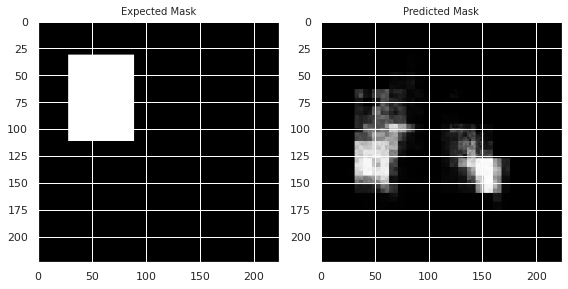

In [27]:
# Prediction for image-5
img = X_test_mobnet[5].astype('uint32')
image_array = np.array([img])
pred_image = savedModel.predict(image_array)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].set_title("Expected Mask", fontsize=10)
ax[0].imshow(y_test_mobnet[5], cmap=plt.cm.gist_gray)
ax[1].set_title("Predicted Mask", fontsize=10)
ax[1].imshow(pred_image[0], cmap=plt.cm.gist_gray)
plt.tight_layout()
plt.show()

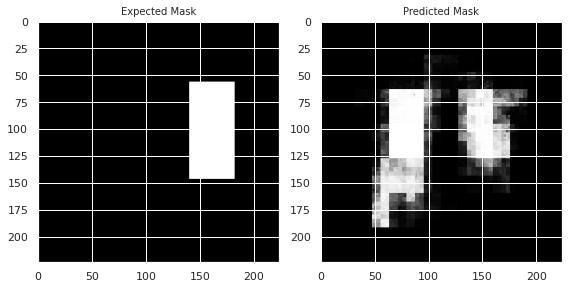

In [26]:
# Prediction for image-15
img = X_test_mobnet[15].astype('uint32')
image_array = np.array([img])
pred_image = savedModel.predict(image_array)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].set_title("Expected Mask", fontsize=10)
ax[0].imshow(y_test_mobnet[15], cmap=plt.cm.gist_gray)
ax[1].set_title("Predicted Mask", fontsize=10)
ax[1].imshow(pred_image[0], cmap=plt.cm.gist_gray)
plt.tight_layout()
plt.show()

#### Step 5.3 Perform prediction with saved model - best weights - during fit

In [28]:
# To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Reading the model from JSON file
with open('OD-MobileNetUnet.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Load the model architecture 
savedModel_best_weights = model_from_json(json_savedModel)

# Reloading the trained weights
savedModel_best_weights.load_weights('OD_UnetMobileNet_CP_Weights.h5')

# Defining optimizer and compile
optimizer = Adam(lr=0.001)
savedModel_best_weights.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient, Recall(), Precision()])

# Run evaluate
savedModel_best_weights.evaluate(X_test_mobnet, y_test_mobnet, batch_size=8)

10/10 [==============================] - 2s 132ms/step - loss: 1.3289 - dice_coefficient: 0.3681 - recall_2: 0.4670 - precision_2: 0.3427


[1.328946828842163,
 0.3681333661079407,
 0.46702438592910767,
 0.3427254259586334]

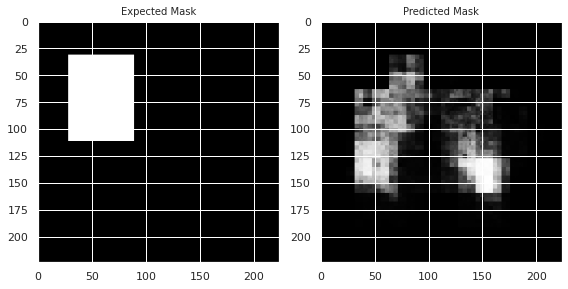

In [29]:
# Prediction for image-5
img = X_test_mobnet[5].astype('uint32')
image_array = np.array([img])
pred_image = savedModel_best_weights.predict(image_array)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].set_title("Expected Mask", fontsize=10)
ax[0].imshow(y_test_mobnet[5], cmap=plt.cm.gist_gray)
ax[1].set_title("Predicted Mask", fontsize=10)
ax[1].imshow(pred_image[0], cmap=plt.cm.gist_gray)
plt.tight_layout()
plt.show()

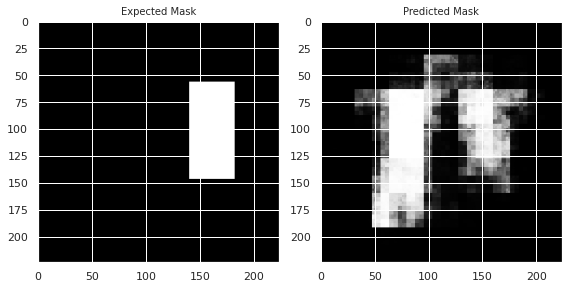

In [30]:
# Prediction for image-15
img = X_test_mobnet[15].astype('uint32')
image_array = np.array([img])
pred_image = savedModel_best_weights.predict(image_array)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].set_title("Expected Mask", fontsize=10)
ax[0].imshow(y_test_mobnet[15], cmap=plt.cm.gist_gray)
ax[1].set_title("Predicted Mask", fontsize=10)
ax[1].imshow(pred_image[0], cmap=plt.cm.gist_gray)
plt.tight_layout()
plt.show()